In [1]:
# A1) Imports e versão
import sys, os, json, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pprint import pprint

import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, f1_score, confusion_matrix, classification_report)

np.random.seed(42)
print("Python:", sys.version)
print("sklearn:", sklearn.__version__)


Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
sklearn: 1.7.1


In [2]:
# B1) Carregar WDBC (as_frame=True para DataFrame)
data = load_breast_cancer(as_frame=True)
X_full = data.frame[data.feature_names].copy()
y_num = data.target.copy()                # 0=malignant, 1=benign
y = np.where(y_num==0, "Maligno", "Benigno")  # mapeia p/ strings (consistente com a API)

X_full.shape, pd.Series(y).value_counts(normalize=True).round(3)


((569, 30),
 Benigno    0.627
 Maligno    0.373
 Name: proportion, dtype: float64)

In [3]:
# C1) Train/Test estratificado (20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((455, 30), (114, 30))

In [4]:
from sklearn.feature_selection import mutual_info_classif

features = list(X_train.columns)

# D1) Mutual Information (univariado)
mi = mutual_info_classif(X_train[features], y_train, discrete_features=False, random_state=42)
rank_mi = pd.Series(mi, index=features).sort_values(ascending=False)

# D2) RandomForest importances
rf = RandomForestClassifier(
    n_estimators=600, max_depth=None, n_jobs=-1, random_state=42, class_weight=None
)
rf.fit(X_train, y_train)
rf_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# D3) Logistic Regression (coeficientes absolutos) COM pipeline (imputer+scaler)
log_pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), features)
    ], remainder="drop")),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])
log_pipe.fit(X_train, y_train)
# extrair coeficientes
log_coef = pd.Series(
    np.abs(log_pipe.named_steps["clf"].coef_[0]),
    index=features
).sort_values(ascending=False)

# D4) Consolida rankings por soma de posições
def ranks(series_desc):
    # retorna posição (1=mais importante) para cada feature
    return series_desc.rank(ascending=False, method="min")

rank_df = pd.DataFrame({
    "rank_mi": ranks(rank_mi),
    "rank_rf": ranks(rf_imp),
    "rank_logcoef": ranks(log_coef),
})
rank_df["rank_sum"] = rank_df.sum(axis=1)
rank_df = rank_df.sort_values("rank_sum")

# Top-15 para inspeção
rank_df.head(15)


,rank_mi,rank_rf,rank_logcoef,rank_sum
worst area,3.0,2.0,6.0,11.0
mean concave points,4.0,5.0,4.0,13.0
worst radius,1.0,4.0,9.0,14.0
worst perimeter,2.0,1.0,12.0,15.0
worst concave points,5.0,3.0,13.0,21.0
area error,10.0,10.0,5.0,25.0
mean concavity,9.0,8.0,10.0,27.0
worst texture,16.0,12.0,1.0,29.0
worst concavity,11.0,11.0,8.0,30.0
radius error,13.0,16.0,2.0,31.0


In [5]:
TOP_K = 10
selected = list(rank_df.index[:TOP_K])
selected


['worst area',
 'mean concave points',
 'worst radius',
 'worst perimeter',
 'worst concave points',
 'area error',
 'mean concavity',
 'worst texture',
 'worst concavity',
 'radius error']

In [6]:
# E1) Pipeline final (somente as 10 selecionadas)
prep = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), selected)
    ],
    remainder="drop"
)
clf = LogisticRegression(max_iter=2000, solver="liblinear")
pipe = Pipeline([("prep", prep), ("clf", clf)])

# E2) Validação cruzada no TRAIN
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_cv = cross_val_score(pipe, X_train[selected], y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
acc_cv = cross_val_score(pipe, X_train[selected], y_train, cv=cv, scoring="accuracy", n_jobs=-1).mean()
print(f"[CV] AUC={auc_cv:.4f} | ACC={acc_cv:.4f}")

# E3) Fit final no TRAIN e avaliação no TEST
pipe.fit(X_train[selected], y_train)

proba_test = pipe.predict_proba(X_test[selected])
# índice da classe 'Maligno' (robusto a ordem interna)
classes = list(pipe.named_steps["clf"].classes_)
idx_m = next((i for i,c in enumerate(classes) if str(c).lower().startswith("malign")), 0)
p_mal = proba_test[:, idx_m]

auc_test = roc_auc_score((y_test=="Maligno").astype(int), p_mal)
print(f"[TEST] ROC-AUC={auc_test:.4f}")


[CV] AUC=0.9953 | ACC=0.9626
[TEST] ROC-AUC=0.9960


In [8]:
y_true = (y_test == "Maligno").astype(int)

fpr, tpr, thr_roc = roc_curve(y_true, p_mal)
prec, rec, thr_pr = precision_recall_curve(y_true, p_mal)

# 1) Youden J
youden = tpr - fpr
t_idx = np.argmax(youden)
thr_youden = thr_roc[t_idx]

# 2) Melhor F1 no PR-curve
# obs: thr_pr tem len = len(prec)-1
f1s = 2 * prec * rec / (prec + rec + 1e-9)
f1_idx = np.nanargmax(f1s)
thr_f1 = thr_pr[max(f1_idx - 1, 0)]

# 3) Recall alvo (>= 0.95) com melhor precisão
RECALL_TARGET = 0.95
mask = rec[1:] >= RECALL_TARGET  # alinhar tamanho com thr_pr
thr_recall = thr_pr[mask][0] if mask.any() else 0.5

def eval_at(thr):
    y_hat = (p_mal >= thr).astype(int)
    return dict(
        thr=float(thr),
        acc=accuracy_score(y_true, y_hat),
        f1=f1_score(y_true, y_hat),
        recall=(y_true[y_hat == 1].sum() / y_true.sum()) if y_true.sum() else 0.0,
        auc=float(auc_test)
    )

print("Sugeridos:")
print(" - Youden J :", eval_at(thr_youden))
print(" - F1       :", eval_at(thr_f1))
print(" - Recall95 :", eval_at(thr_recall))


Sugeridos:
 - Youden J : {'thr': 0.6156924870936324, 'acc': 0.9736842105263158, 'f1': 0.963855421686747, 'recall': np.float64(0.9523809523809523), 'auc': 0.996031746031746}
 - F1       : {'thr': 0.42654057607833834, 'acc': 0.9649122807017544, 'f1': 0.9523809523809523, 'recall': np.float64(0.9523809523809523), 'auc': 0.996031746031746}
 - Recall95 : {'thr': 9.761205887260085e-06, 'acc': 0.3684210526315789, 'f1': 0.5384615384615384, 'recall': np.float64(1.0), 'auc': 0.996031746031746}


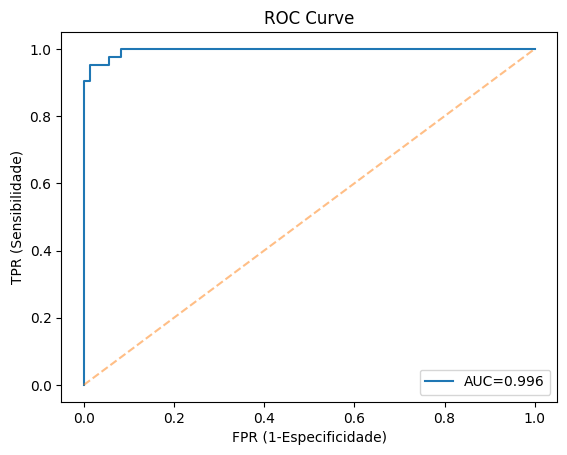

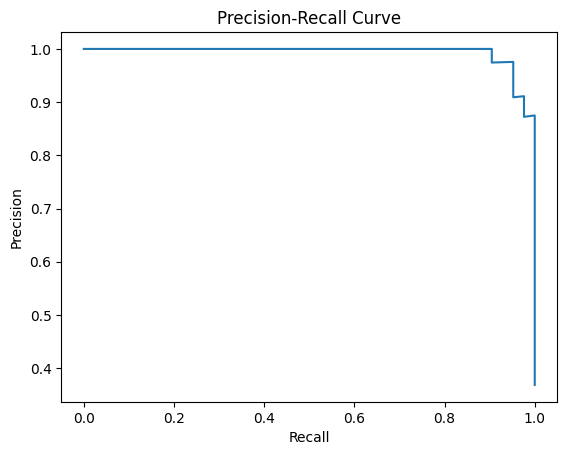

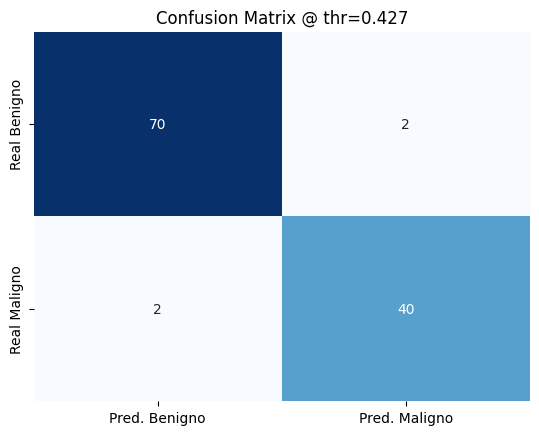

              precision    recall  f1-score   support

     Benigno       0.97      0.97      0.97        72
     Maligno       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

Use este THRESHOLD no .env do backend: 0.42654057607833834


In [9]:
# ROC
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc_test:.3f}")
plt.plot([0,1],[0,1],'--',alpha=.5)
plt.xlabel("FPR (1-Especificidade)"); plt.ylabel("TPR (Sensibilidade)"); plt.title("ROC Curve")
plt.legend(); plt.show()

# PR
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.show()

# Matriz de confusão no threshold escolhido (ex.: F1)
thr = float(thr_f1)   # <-- ajuste se escolher outro
y_hat = (p_mal >= thr).astype(int)
cm = confusion_matrix(y_true, y_hat)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred. Benigno","Pred. Maligno"],
            yticklabels=["Real Benigno","Real Maligno"])
plt.title(f"Confusion Matrix @ thr={thr:.3f}")
plt.show()

print(classification_report(y_true, y_hat, target_names=["Benigno","Maligno"]))
print("Use este THRESHOLD no .env do backend:", thr)


In [11]:
# H1) Treinar pipeline final com TODA A BASE (opcional)
#    Se preferir manter holdout, comente esta célula.
pipe.fit(X_full[selected], y)

# H2) Paths
base = Path(".")
models_dir = base/"backend"/"models"
models_dir.mkdir(parents=True, exist_ok=True)

# H3) Salvar modelo
joblib.dump(pipe, models_dir/"best_model.pkl")

# H4) Salvar lista de features (ordem)
with open(models_dir/"selected_features.json", "w", encoding="utf-8") as f:
    json.dump({"selected_features": selected}, f, ensure_ascii=False, indent=2)

# H5) Exemplos medianos reais (para botões do front)
df = X_full[selected].copy()
df["label"] = y
stats = df.groupby("label").median(numeric_only=True)

benign = [float(stats.loc["Benigno", c]) for c in selected]
malign = [float(stats.loc["Maligno", c]) for c in selected]

with open(models_dir/"examples_10.json", "w", encoding="utf-8") as f:
    json.dump({
        "selected_features": selected,
        "benign_median": benign,
        "malignant_median": malign
    }, f, ensure_ascii=False, indent=2)

print("[OK] Artefatos salvos em", models_dir.resolve())


[OK] Artefatos salvos em C:\Users\DAVI LOPES\Desktop\Pós Tech\tech-challenge\notebooks\backend\models


In [12]:
m = joblib.load(models_dir/"best_model.pkl")
sample = X_test[selected].iloc[[0]]
proba = m.predict_proba(sample)[0]
classes = list(m.named_steps["clf"].classes_)
idx_m = next((i for i,c in enumerate(classes) if str(c).lower().startswith("malign")), 0)
print("p(Maligno)=", float(proba[idx_m]))
print("Diagnóstico @thr:", "Maligno" if proba[idx_m]>=thr else "Benigno")


p(Maligno)= 0.0002594937060203394
Diagnóstico @thr: Benigno


In [13]:
import joblib
model = joblib.load("backend/models/best_model.pkl")
print(model.n_features_in_)
print(model.feature_names_in_)


10
['worst area' 'mean concave points' 'worst radius' 'worst perimeter'
 'worst concave points' 'area error' 'mean concavity' 'worst texture'
 'worst concavity' 'radius error']
